<a href="https://colab.research.google.com/github/basilsaju383/Deep-Learning-Projects/blob/main/Anomaly_detection_using_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [ ]:
df = pd.read_excel('/content/sample_data/mc4 GSM 3 month.xlsx')
df = df[['Date','RSSI']]
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4654 entries, 1918 to 132349
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4654 non-null   datetime64[ns]
 1   RSSI    4654 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 109.1 KB


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['RSSI']).reshape(-1,1))

train['RSSI'] = scaler.transform(np.array(train['RSSI']).reshape(-1,1))
test['RSSI'] = scaler.transform(np.array(test['RSSI']).reshape(-1,1))

In [ ]:
TIME_STEPS=50

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['RSSI']], train['RSSI'])
X_test, y_test = create_sequences(test[['RSSI']], test['RSSI'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3673, 50, 1)
Testing input shape:  (881, 50, 1)


In [ ]:
np.random.seed(21)
tf.random.set_seed(21)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=150, # how many epochs to wait before stopping
    restore_best_weights=True,
)
model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'relu', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(128, activation = 'relu', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.9
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 50, 128)           0         
 tor)                                                            
                                                                 
 lstm_16 (LSTM)              (None, 50, 128)           131584    
                                                                 
 dropout_16 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 50, 128)           131584    
                                                      

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    shuffle=False)

Epoch 1/500
52/52 [==============================] - 22s 342ms/step - loss: 1.0098 - val_loss: 0.9294
Epoch 2/500
52/52 [==============================] - 20s 384ms/step - loss: 1.0084 - val_loss: 0.9289
Epoch 3/500
52/52 [==============================] - 22s 422ms/step - loss: 1.0080 - val_loss: 0.9279
Epoch 4/500
52/52 [==============================] - 18s 341ms/step - loss: 1.0074 - val_loss: 23949.0820
Epoch 5/500
52/52 [==============================] - 16s 316ms/step - loss: 1.0092 - val_loss: 0.9295
Epoch 6/500
52/52 [==============================] - 17s 331ms/step - loss: 1.0077 - val_loss: 0.9292
Epoch 7/500
52/52 [==============================] - 18s 346ms/step - loss: 1.0072 - val_loss: 0.9280
Epoch 8/500
52/52 [==============================] - 17s 323ms/step - loss: 1.0083 - val_loss: 0.9288
Epoch 9/500
52/52 [==============================] - 17s 320ms/step - loss: 1.0072 - val_loss: 0.9260
Epoch 10/500
52/52 [==============================] - 18s 342ms/step - loss: 1

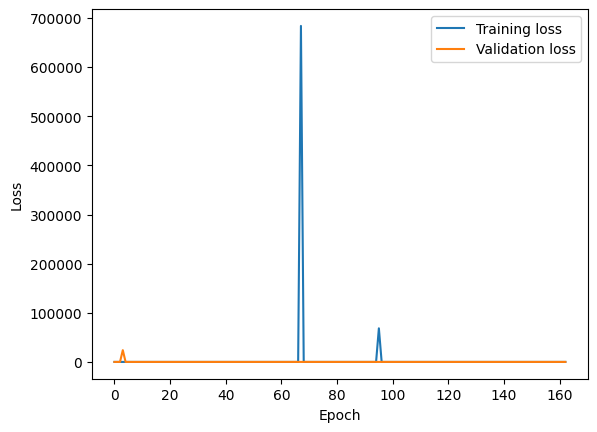

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(21)
tf.random.set_seed(21)

def create_sequences(X, y, time_steps=100):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

df = pd.read_excel('/content/sample_data/mc4 GSM 3 month.xlsx')
df = df[['Date','RSSI']]
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()

train, test = train_test_split(df, test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['RSSI']).reshape(-1,1))

train['RSSI'] = scaler.transform(np.array(train['RSSI']).reshape(-1,1))
test['RSSI'] = scaler.transform(np.array(test['RSSI']).reshape(-1,1))

X_train, y_train = create_sequences(train[['RSSI']], train['RSSI'])
X_test, y_test = create_sequences(test[['RSSI']], test['RSSI'])

print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)

model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
model.summary()

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1,
                    shuffle=False)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Training input shape:  (3623, 100, 1)
Testing input shape:  (831, 100, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 256)          264192    
                                                                 
 dropout_18 (Dropout)        (None, 100, 256)          0         
                                                                 
 lstm_19 (LSTM)              (None, 100, 256)          525312    
                                                                 
 dropout_19 (Dropout)        (None, 100, 256)          0         
                                                                 
 lstm_20 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                              

KeyboardInterrupt: 

Epoch 1/20
655/655 [==============================] - 3s 3ms/step - loss: 0.0020
Epoch 2/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 3/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 4/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 5/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 6/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 7/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 8/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 9/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 10/20
655/655 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 11/20
655/655 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 12/20
655/655 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 13/20
655/655 [====

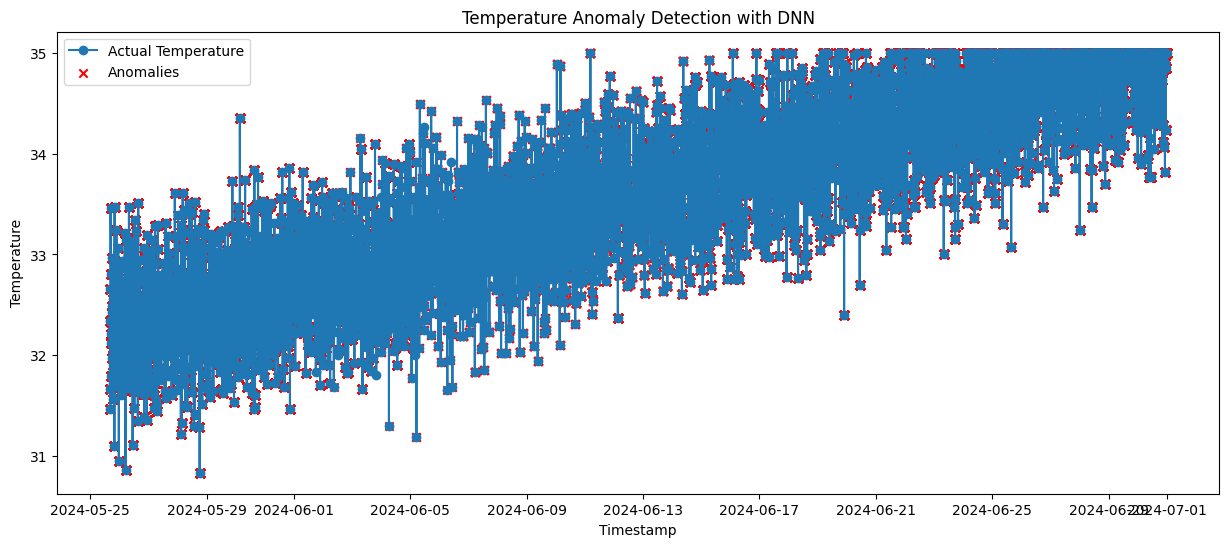

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the simulated sensor data
df = pd.read_excel('/content/sample_data/simulated_sensor_data.xlsx')

# Extract timestamps
timestamps = df['Timestamp']

# Use both Temperature and Humidity columns
data = df[['Temperature', 'Humidity']].values

# Normalize the data to the range [0, 1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert timestamps to Unix timestamps
unix_timestamps = timestamps.astype(np.int64) // 10**9  # Convert nanoseconds to seconds

# Concatenate Unix timestamps with the normalized data
data_with_timestamps = np.concatenate((unix_timestamps.values.reshape(-1, 1), data_scaled), axis=1)

# Split the data into training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_with_timestamps[:train_size], data_with_timestamps[train_size:]

# Function to create sequences for the DNN model
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, 0]  # Temperature is the target variable
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 10

# Create sequences for training and testing for both temperature and humidity
X_train, y_train = create_sequences(train_data[:, 1:], seq_length)  # Exclude timestamps for input data
X_test, y_test = create_sequences(test_data[:, 1:], seq_length)  # Exclude timestamps for input data

# Build the DNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 2)),  # 2 for temperature and humidity
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model with a dummy loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions on the test data
predictions = model.predict(X_test)

# Calculate the Mean Absolute Error (MAE) for each prediction
mae = np.mean(np.abs(predictions - y_test))

# Define a threshold for anomaly detection
threshold = 0.15  # Adjust this value based on your data and requirements

# Identify anomalies based on the threshold
anomalies = np.where(np.abs(predictions - y_test) > threshold)[0]

# Plot the actual values and highlight anomalies
plt.figure(figsize=(15, 6))
plt.plot(timestamps.iloc[-len(test_data) + seq_length:], scaler.inverse_transform(test_data[seq_length:, 1:])[:, 0], label='Actual Temperature', marker='o')
plt.scatter(timestamps.iloc[-len(test_data) + seq_length + anomalies], scaler.inverse_transform(test_data[seq_length + anomalies, 1:])[:, 0], color='red', marker='x', label='Anomalies')
plt.title('Temperature Anomaly Detection with DNN')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the simulated sensor data
df = pd.read_excel('/content/sample_data/simulated_sensor_data.xlsx')

# Extract timestamps
timestamps = df['Timestamp']
df.head()

,Timestamp,Temperature,Humidity
0,2024-01-01 00:00:00,21.248357,94.357192
1,2024-01-01 00:10:00,21.000000,95.000000
2,2024-01-01 00:20:00,21.324913,94.214297
3,2024-01-01 00:30:00,21.763118,94.103690
4,2024-01-01 00:40:00,21.000000,94.927776
